# Subgrid tendency analysis

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

from modules import tools


In [2]:
base_path = '/srv/ccrc/AtmSS/z5310829/honours_project/'
fig_path = base_path + 'figures/thesis/04_tendencies/'
data_path = base_path + 'data/training/'

ASPECT = 8.
VARS = {'u': '$u$', 'w': '$w$', 'theta': '$\\theta$'}
BC = {'u': (0, 0), 'w': (0, 0), 'theta': (1/2, -1/2)}
TEND_BC = {'u': (0, 0), 'w': (0, 0), 'theta': (0, 0)}  # remove later


In [3]:
coarse_t = xr.open_mfdataset(
    data_path + '256x64_from_2048x256_diffused_t/*.nc').compute()
# true_coarse_dt = xr.open_mfdataset().compute()
pred_coarse_dt = xr.open_mfdataset(
    data_path + '256x64_from_2048x256_diffused_tplusdt/*.nc').compute()

coarse_t = tools.insert_bc(coarse_t, BC, ASPECT)
# true_coarse_dt = tools.insert_bc(true_coarse_dt, BC, ASPECT)
pred_coarse_dt = tools.insert_bc(pred_coarse_dt, BC, ASPECT)

coarse_t = coarse_t.isel(t=(coarse_t.t < 299))
# true_coarse_dt = true_coarse_dt.isel(t=(true_coarse_dt.t < 299))
pred_coarse_dt = pred_coarse_dt.isel(t=(pred_coarse_dt.t < 299))

true_coarse_tend = xr.open_dataset(
    data_path + '2048x256_tend_256x64/2048x256_tend_256x64.nc').compute()
true_coarse_tend = tools.insert_bc(true_coarse_tend, TEND_BC, ASPECT)
# true_coarse_tend = tools.tendency(coarse_t, true_coarse_dt)
pred_coarse_tend = tools.tendency(coarse_t, pred_coarse_dt)
subgrid_tend = true_coarse_tend - pred_coarse_tend


In [4]:
N_SAMPLES = coarse_t.x.size*coarse_t.z.size


## Example plot

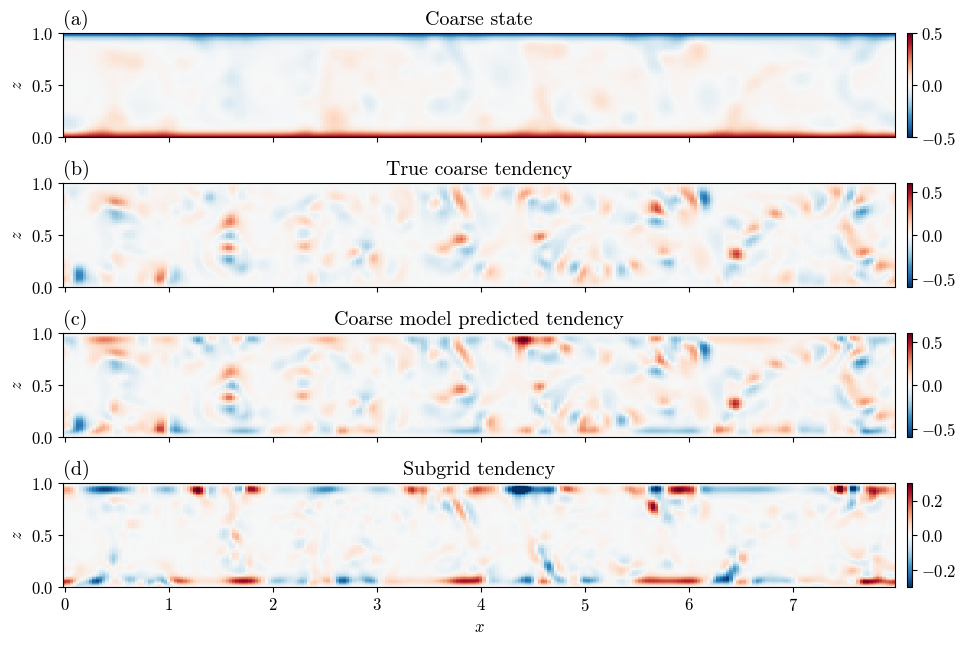

In [4]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 6.5))

mesh = axes[0].pcolormesh(
    coarse_t.x, coarse_t.z, coarse_t.theta.isel(t=-1).T,
    vmin=-1/2, vmax=1/2, cmap='RdBu_r'
)
axes[0].set(aspect='equal', ylabel='$z$', title='Coarse state')
fig.colorbar(mesh, ax=axes[0], pad=0.01)

mesh = axes[1].pcolormesh(
    true_coarse_tend.x, true_coarse_tend.z,
    true_coarse_tend.theta.isel(t=-1).T,
    vmin=-0.6, vmax=0.6, cmap='RdBu_r'
)
axes[1].set(aspect='equal', ylabel='$z$', title='True coarse tendency')
fig.colorbar(mesh, ax=axes[1], pad=0.01)

mesh = axes[2].pcolormesh(
    pred_coarse_tend.x, pred_coarse_tend.z,
    pred_coarse_tend.theta.isel(t=-1).T,
    vmin=-0.6, vmax=0.6, cmap='RdBu_r'
)
axes[2].set(
    aspect='equal', ylabel='$z$', title='Coarse model predicted tendency',
)
fig.colorbar(mesh, ax=axes[2], pad=0.01)

mesh = axes[3].pcolormesh(
    subgrid_tend.x, subgrid_tend.z, subgrid_tend.theta.isel(t=-1).T,
    vmin=-0.3, vmax=0.3, cmap='RdBu_r'
)
axes[3].set(
    aspect='equal', ylabel='$z$', xlabel='$x$', title='Subgrid tendency',
)
fig.colorbar(mesh, ax=axes[3], pad=0.01)

tools.label_subplots(axes)
fig.tight_layout()


## Analysis

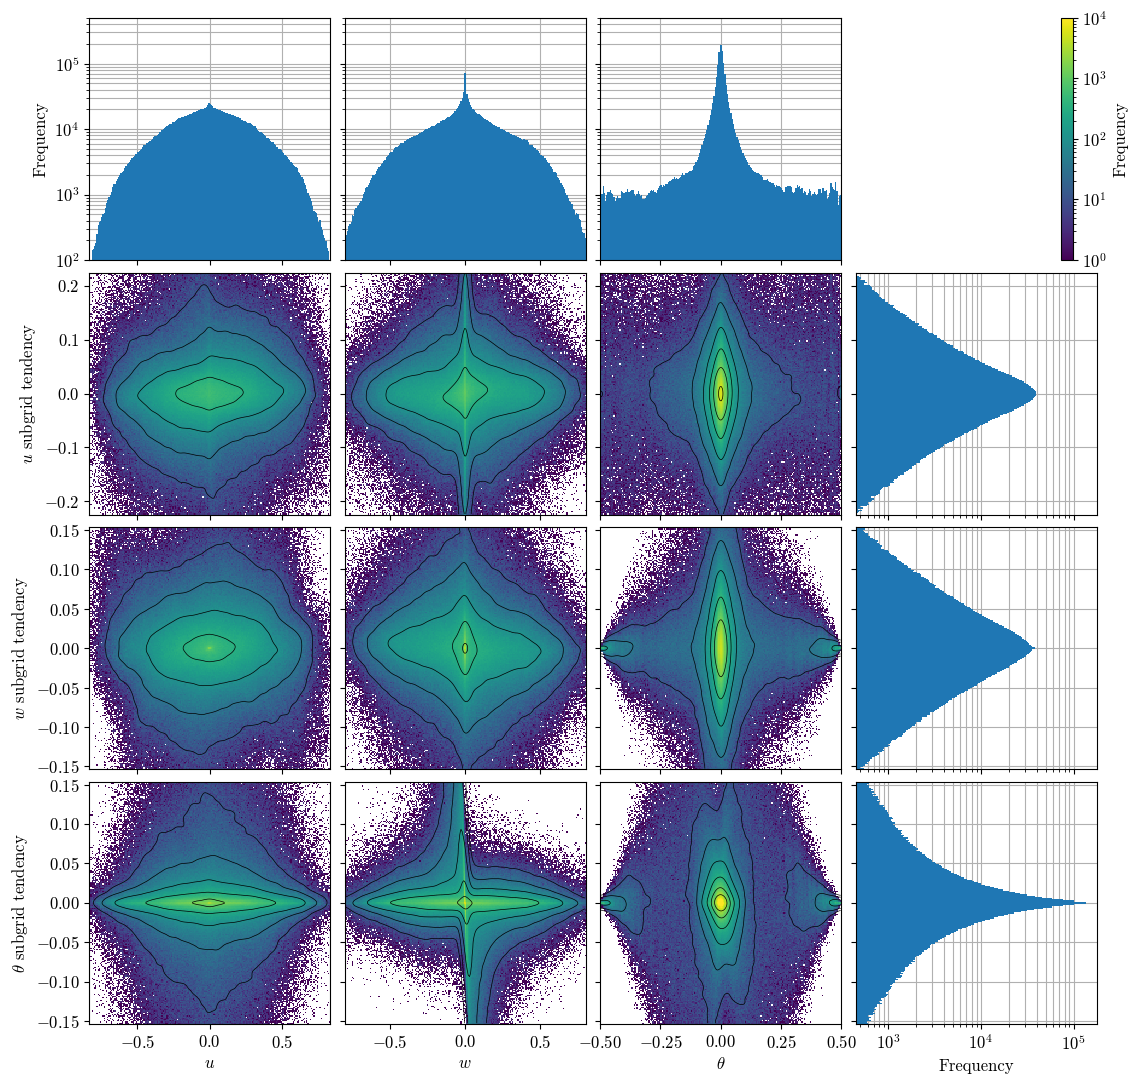

In [46]:
rng = np.random.default_rng(seed=0)
x_sample = rng.uniform(0, ASPECT, N_SAMPLES)
z_sample = rng.uniform(0, 1, N_SAMPLES)
hist1d_nbins = hist2d_nbins = 200
n_std = 3

fig, axes = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(11.5, 11))
for i, (tend_var, tend_name) in enumerate(VARS.items()):
    tend_data = tools.sample(
        subgrid_tend[tend_var], x_sample, z_sample,
    ).ravel()
    tend_lim = n_std*tend_data.std()
    axes[i+1,0].set_ylabel(f'{tend_name} subgrid tendency')

    # Tendency marginal histogram
    axes[i+1,3].hist(
        tend_data, bins=hist1d_nbins, orientation='horizontal',
        range=(-tend_lim, tend_lim), color='tab:blue',
        histtype='stepfilled', log=True
    )
    axes[i+1,3].grid(True, which='both')
    axes[i+1,3].set_axisbelow(True)

    for j, (state_var, state_name) in enumerate(VARS.items()):
        state_data = tools.sample(
            coarse_t[state_var], x_sample, z_sample,
        ).ravel()
        state_lim = 0.5 if state_var == 'theta' else n_std*state_data.std()

        # Joint histogram
        hist, x, y, mesh = axes[i+1,j].hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
            norm='log', vmin=1, vmax=1e4, rasterized=True,
        )
        tools.hist_contour(axes[i+1,j], x, y, hist, sigma=2.5)

        if i == 0:
            # State variable marginal histogram
            axes[0,j].hist(
                state_data, bins=hist1d_nbins,
                range=(-state_lim, state_lim), color='tab:blue',
                histtype='stepfilled', log=True
            )
            axes[0,j].set_ylim(1e2, 5e5)
            axes[0,j].grid(True, which='both')
            axes[0,j].set_axisbelow(True)
            axes[-1,j].set_xlabel(state_name)

fig.colorbar(mesh, ax=axes[0,-1], label='Frequency')
axes[0,0].set_ylabel('Frequency')
axes[-1,-1].set_xlabel('Frequency')
axes[0,-1].remove()
fig.tight_layout(h_pad=0.1, w_pad=-0.2)


In [5]:
RANGES = [
    (0., 1.), (0., 0.1), (0.1, 0.25), (0.25, 0.75), (0.75, 0.9), (0.9, 1.),
]


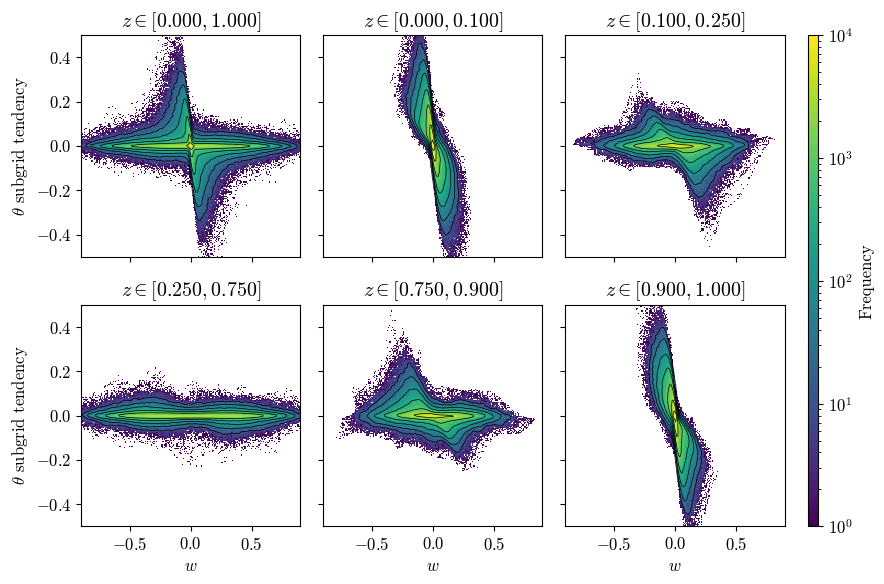

In [11]:
fig = plt.figure(figsize=(9, 6))
n_rows, n_cols = 2, 3
gs = plt.GridSpec(n_rows, n_cols+1, width_ratios=[1, 1, 1, 0.05])
axes = np.array([
    [fig.add_subplot(gs[i,j]) for j in range(n_cols)] for i in range(n_rows)
])
for ax in axes[:-1,:].flat: ax.set_xticklabels([])
for ax in axes[:,1:].flat: ax.set_yticklabels([])

meshes = tools.plot_z_dependence(
    coarse_t.w, subgrid_tend.theta,
    axes=axes, z_ranges=RANGES, n_samples=N_SAMPLES, aspect=ASPECT, sigma=1,
    bins=[200, 200], range=[[-0.9, 0.9], [-0.5, 0.5]], vmin=1, vmax=1e4,
)
fig.colorbar(meshes[0,0], cax=fig.add_subplot(gs[:,-1]), label='Frequency')

for ax in axes[-1,:]: ax.set_xlabel('$w$')
for ax in axes[:,0]: ax.set_ylabel('$\\theta$ subgrid tendency')

fig.tight_layout()


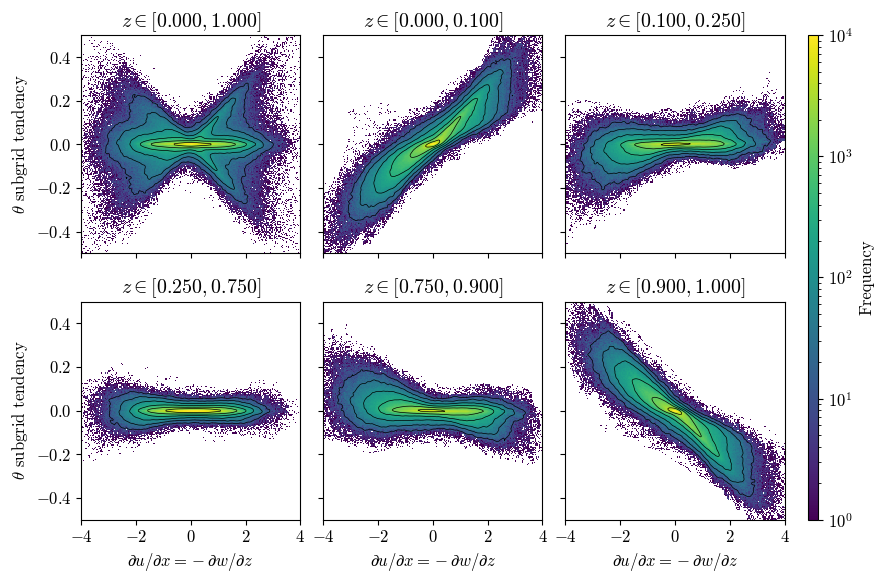

In [7]:
fig = plt.figure(figsize=(9, 6))
n_rows, n_cols = 2, 3
gs = plt.GridSpec(n_rows, n_cols+1, width_ratios=[1, 1, 1, 0.05])
axes = np.array([
    [fig.add_subplot(gs[i,j]) for j in range(n_cols)] for i in range(n_rows)
])
for ax in axes[:-1,:].flat: ax.set_xticklabels([])
for ax in axes[:,1:].flat: ax.set_yticklabels([])

meshes = tools.plot_z_dependence(
    coarse_t.u.differentiate('x', edge_order=2), subgrid_tend.theta,
    axes=axes, z_ranges=RANGES, n_samples=N_SAMPLES, aspect=ASPECT, sigma=1,
    bins=[200, 200], range=[[-4, 4], [-0.5, 0.5]], vmin=1, vmax=1e4,
)
fig.colorbar(meshes[0,0], cax=fig.add_subplot(gs[:,-1]), label='Frequency')

for ax in axes[-1,:]: ax.set_xlabel(
    '$\\partial u / \\partial x = -\\partial w / \\partial z$')
for ax in axes[:,0]: ax.set_ylabel('$\\theta$ subgrid tendency')

fig.tight_layout()


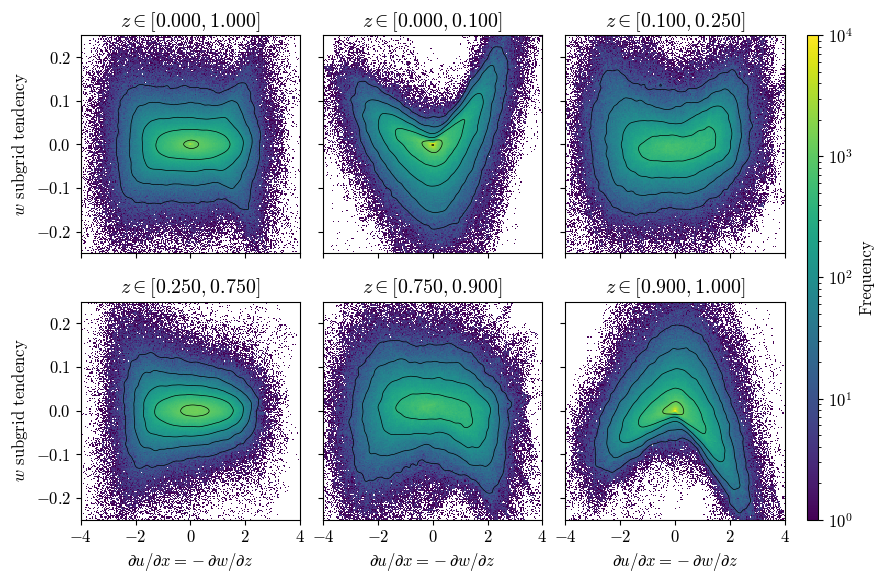

In [8]:
fig = plt.figure(figsize=(9, 6))
n_rows, n_cols = 2, 3
gs = plt.GridSpec(n_rows, n_cols+1, width_ratios=[1, 1, 1, 0.05])
axes = np.array([
    [fig.add_subplot(gs[i,j]) for j in range(n_cols)] for i in range(n_rows)
])
for ax in axes[:-1,:].flat: ax.set_xticklabels([])
for ax in axes[:,1:].flat: ax.set_yticklabels([])

meshes = tools.plot_z_dependence(
    coarse_t.u.differentiate('x', edge_order=2), subgrid_tend.w,
    axes=axes, z_ranges=RANGES, n_samples=N_SAMPLES, aspect=ASPECT, sigma=2,
    bins=[200, 200], range=[[-4, 4], [-0.25, 0.25]], vmin=1, vmax=1e4,
)
fig.colorbar(meshes[0,0], cax=fig.add_subplot(gs[:,-1]), label='Frequency')

for ax in axes[-1,:]: ax.set_xlabel(
    '$\\partial u / \\partial x = -\\partial w / \\partial z$')
for ax in axes[:,0]: ax.set_ylabel('$w$ subgrid tendency')

fig.tight_layout()


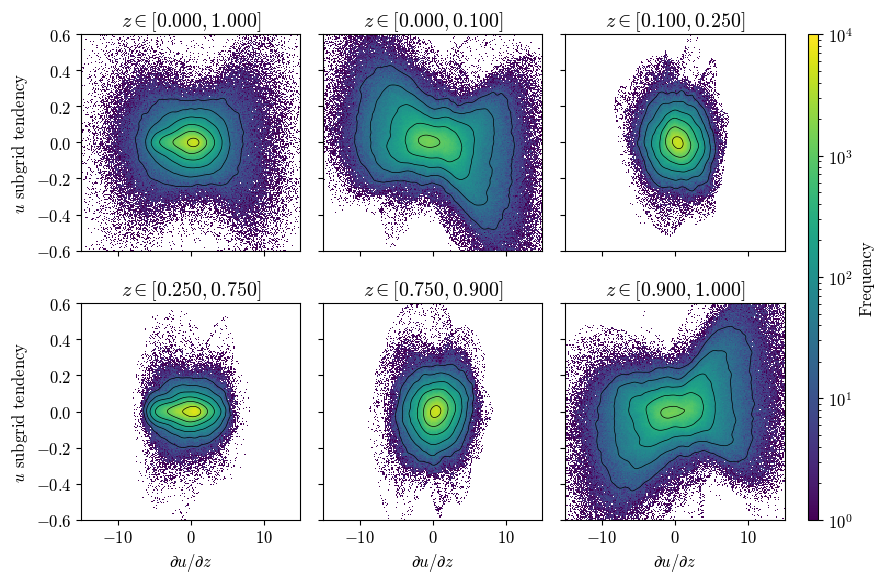

In [9]:
fig = plt.figure(figsize=(9, 6))
n_rows, n_cols = 2, 3
gs = plt.GridSpec(n_rows, n_cols+1, width_ratios=[1, 1, 1, 0.05])
axes = np.array([
    [fig.add_subplot(gs[i,j]) for j in range(n_cols)] for i in range(n_rows)
])
for ax in axes[:-1,:].flat: ax.set_xticklabels([])
for ax in axes[:,1:].flat: ax.set_yticklabels([])

meshes = tools.plot_z_dependence(
    coarse_t.u.differentiate('z', edge_order=2), subgrid_tend.u,
    axes=axes, z_ranges=RANGES, n_samples=N_SAMPLES, aspect=ASPECT, sigma=2,
    bins=[200, 200], range=[[-15, 15], [-0.6, 0.6]], vmin=1, vmax=1e4,
)
fig.colorbar(meshes[0,0], cax=fig.add_subplot(gs[:,-1]), label='Frequency')

for ax in axes[-1,:]: ax.set_xlabel('$\\partial u / \\partial z$')
for ax in axes[:,0]: ax.set_ylabel('$u$ subgrid tendency')

fig.tight_layout()


## Resolved tendency relationship

In [36]:
RANGES = [
    (0., 1.), (0., 0.05), (0.1, 0.15), (0.475, 0.525), (0.85, 0.9), (0.95, 1.),
]
MAX_N = 10
x_predict = np.array([-2., 2.])


In [25]:
rng = np.random.default_rng(seed=0)
x_sample = rng.uniform(0, ASPECT, N_SAMPLES)
z_sample = rng.uniform(0, 1, N_SAMPLES)

def fit(pred_tend, subgrid_tend, max_n):
    subgrid_tend = tools.sample(subgrid_tend, x_sample, z_sample)
    pred_tend = tools.sample(pred_tend, x_sample, z_sample)
    regressors = np.column_stack([
        (np.atleast_2d((z_sample - 1/2)**(2*n)).T * pred_tend).ravel()
        for n in range(max_n + 1)
    ])
    model = sm.OLS(subgrid_tend.ravel(), regressors)
    results = model.fit()
    print(results.summary())
    return results

def predict(result, pred_tend, z, max_n):
    x = np.column_stack([
        (z - 1/2)**(2*n) * pred_tend for n in range(max_n + 1)
    ])
    return result.predict(x)


In [26]:
theta_result = fit(pred_coarse_tend.theta, subgrid_tend.theta, MAX_N)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                 5.161e+05
Date:                Tue, 31 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:16:41   Log-Likelihood:             3.8199e+06
No. Observations:             1696200   AIC:                        -7.640e+06
Df Residuals:                 1696189   BIC:                        -7.640e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0016      0.001      1.386      0.1

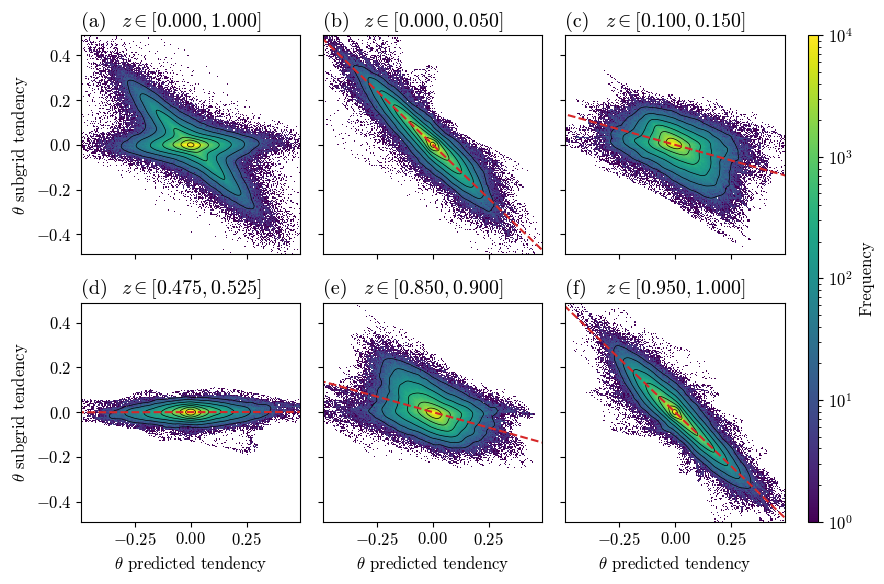

In [37]:
fig = plt.figure(figsize=(9, 6))
n_rows, n_cols = 2, 3
gs = plt.GridSpec(n_rows, n_cols+1, width_ratios=[1, 1, 1, 0.05])
axes = np.array([
    [fig.add_subplot(gs[i,j]) for j in range(n_cols)] for i in range(n_rows)
])
for ax in axes[:-1,:].flat: ax.set_xticklabels([])
for ax in axes[:,1:].flat: ax.set_yticklabels([])

meshes = tools.plot_z_dependence(
    pred_coarse_tend.theta, subgrid_tend.theta,
    axes=axes, z_ranges=RANGES, n_samples=N_SAMPLES, aspect=ASPECT, sigma=2,
    bins=[200, 200], range=[[-0.49, 0.49], [-0.49, 0.49]], vmin=1, vmax=1e4,
)
fig.colorbar(meshes[0,0], cax=fig.add_subplot(gs[:,-1]), label='Frequency')

for i in range(1, 6):
    prediction = predict(theta_result, x_predict, sum(RANGES[i])/2, MAX_N)
    axes.flat[i].plot(x_predict, prediction, color='tab:red', linestyle='--')

for ax in axes[-1,:]: ax.set_xlabel('$\\theta$ predicted tendency')
for ax in axes[:,0]: ax.set_ylabel('$\\theta$ subgrid tendency')
tools.label_subplots(axes)

fig.tight_layout()


In [33]:
u_result = fit(pred_coarse_tend.u, subgrid_tend.u, MAX_N)


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.331
Model:                            OLS   Adj. R-squared (uncentered):              0.331
Method:                 Least Squares   F-statistic:                          7.614e+04
Date:                Tue, 31 Oct 2023   Prob (F-statistic):                        0.00
Time:                        20:20:24   Log-Likelihood:                      2.3303e+06
No. Observations:             1696200   AIC:                                 -4.661e+06
Df Residuals:                 1696189   BIC:                                 -4.660e+06
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

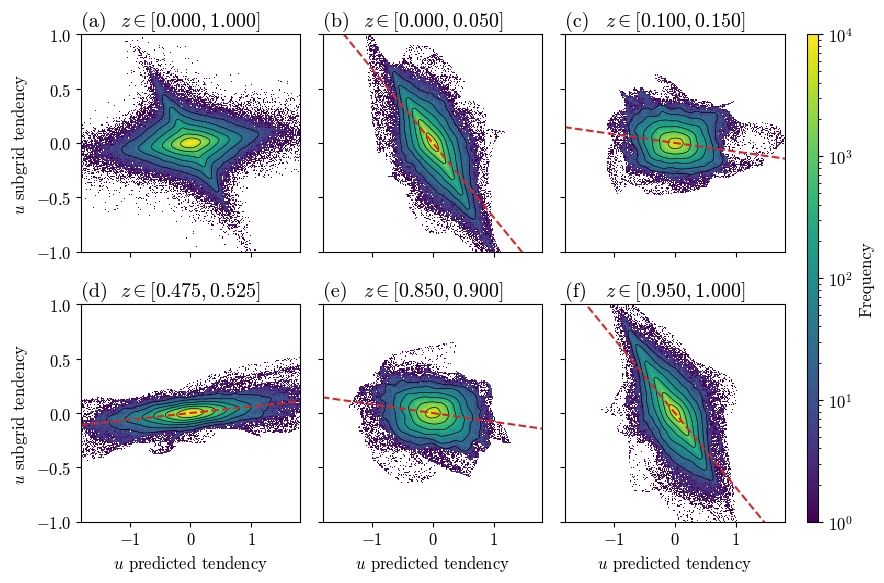

In [38]:
fig = plt.figure(figsize=(9, 6))
n_rows, n_cols = 2, 3
gs = plt.GridSpec(n_rows, n_cols+1, width_ratios=[1, 1, 1, 0.05])
axes = np.array([
    [fig.add_subplot(gs[i,j]) for j in range(n_cols)] for i in range(n_rows)
])
for ax in axes[:-1,:].flat: ax.set_xticklabels([])
for ax in axes[:,1:].flat: ax.set_yticklabels([])

meshes = tools.plot_z_dependence(
    pred_coarse_tend.u, subgrid_tend.u,
    axes=axes, z_ranges=RANGES, n_samples=N_SAMPLES, aspect=ASPECT, sigma=2,
    bins=[200, 200], range=[[-1.8, 1.8], [-1, 1]], vmin=1, vmax=1e4,
)
fig.colorbar(meshes[0,0], cax=fig.add_subplot(gs[:,-1]), label='Frequency')

for i in range(1, 6):
    prediction = predict(u_result, x_predict, sum(RANGES[i])/2, MAX_N)
    axes.flat[i].plot(x_predict, prediction, color='tab:red', linestyle='--')

for ax in axes[-1,:]: ax.set_xlabel('$u$ predicted tendency')
for ax in axes[:,0]: ax.set_ylabel('$u$ subgrid tendency')
tools.label_subplots(axes)

fig.tight_layout()


In [39]:
w_result = fit(pred_coarse_tend.w, subgrid_tend.w, MAX_N)


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.067
Model:                            OLS   Adj. R-squared (uncentered):              0.067
Method:                 Least Squares   F-statistic:                          1.111e+04
Date:                Tue, 31 Oct 2023   Prob (F-statistic):                        0.00
Time:                        20:23:39   Log-Likelihood:                      2.6949e+06
No. Observations:             1696200   AIC:                                 -5.390e+06
Df Residuals:                 1696189   BIC:                                 -5.390e+06
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

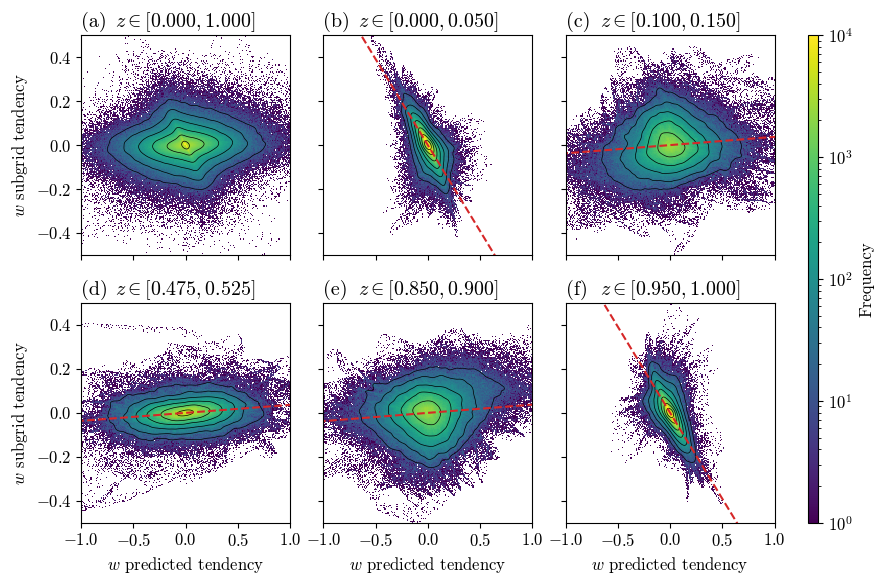

In [40]:
fig = plt.figure(figsize=(9, 6))
n_rows, n_cols = 2, 3
gs = plt.GridSpec(n_rows, n_cols+1, width_ratios=[1, 1, 1, 0.05])
axes = np.array([
    [fig.add_subplot(gs[i,j]) for j in range(n_cols)] for i in range(n_rows)
])
for ax in axes[:-1,:].flat: ax.set_xticklabels([])
for ax in axes[:,1:].flat: ax.set_yticklabels([])

meshes = tools.plot_z_dependence(
    pred_coarse_tend.w, subgrid_tend.w,
    axes=axes, z_ranges=RANGES, n_samples=N_SAMPLES, aspect=ASPECT, sigma=2,
    bins=[200, 200], range=[[-1, 1], [-0.5, 0.5]], vmin=1, vmax=1e4,
)
fig.colorbar(meshes[0,0], cax=fig.add_subplot(gs[:,-1]), label='Frequency')

for i in range(1, 6):
    prediction = predict(w_result, x_predict, sum(RANGES[i])/2, MAX_N)
    axes.flat[i].plot(x_predict, prediction, color='tab:red', linestyle='--')

for ax in axes[-1,:]: ax.set_xlabel('$w$ predicted tendency')
for ax in axes[:,0]: ax.set_ylabel('$w$ subgrid tendency')
tools.label_subplots(axes)

fig.tight_layout()


### Output to csv

In [43]:
params = pd.DataFrame({
    'theta': theta_result.params,
    'u': u_result.params,
    'w': w_result.params,
})
# params.to_csv(data_path + 'coefficients.csv', index=False)
params


,theta,u,w
0,1.620135e-03,6.043614e-02,3.644962e-02
1,8.124105e+00,2.297483e+00,4.918089e-01
2,-1.311135e+03,-5.755719e+02,-1.105437e+02
3,7.349262e+04,4.013997e+04,4.964980e+03
4,-2.019819e+06,-1.322727e+06,-1.175347e+05
5,3.087472e+07,2.409690e+07,1.767632e+06
6,-2.779272e+08,-2.600103e+08,-1.775035e+07
7,1.496365e+09,1.695216e+09,1.179807e+08
8,-4.702984e+09,-6.533946e+09,-4.915701e+08
9,7.888024e+09,1.366868e+10,1.143755e+09
